In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la
import argparse
import pickle
import sys
sys.path.append("../") 
from utils_so import *
import scipy.linalg  as sla

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
from tqdm import tqdm, trange
%load_ext autoreload
%autoreload 2
# https://plotly.com/python/static-image-export/ need to install this if you want to save images
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoicmF0bGlmZmxqIiwiYSI6ImNqOGJ4cm8wcjAzN3QyeG1zcnZvMjB5bGUifQ.iRkpBPE-WANBkVc9ffI8ng")

# set flags
verbose=False # print out stuff for debugging
centered=False # centering the data

import random
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
cs=get_colors(100) # sample return:  ['#8af5da', '#fbc08c', '#b741d0']

$\|x^\ast(u)-x^{\tt so}\|^2$

$f_{\tt so}(u)=\frac{1}{2}\|x^\ast(u)-x^{\tt so}\|^2$

$x^\ast(u)=\text{\tt NE}(f_1(x;u),f_2(x;u))$



$\begin{bmatrix}
\nabla_1f_1(;u_1)\\ 
\nabla_2f_2(; u_2)
\end{bmatrix}= \begin{bmatrix}
-(A_{11}-\lambda_1I)^\top x_1-\frac{1}{2}(\xi_1+u_1+A_{12}x_2)\\
-(A_{22}-\lambda_2I)^\top x_2-\frac{1}{2}(\xi_2+u_2+A_{21}x_1)
\end{bmatrix}$

$\begin{bmatrix}
\lambda_1I-A_{11} & -\frac{1}{2}A_{12}\\
-\frac{1}{2}A_{21} & \lambda_2I-A_{22}
\end{bmatrix}\begin{bmatrix}
x_1\\ x_2
\end{bmatrix}-\frac{1}{2}\begin{bmatrix}
\xi_1\\ \xi_2
\end{bmatrix}=\frac{1}{2}\begin{bmatrix}
u_1\\ u_2
\end{bmatrix}$



$\nabla_u f_{\tt so}(u)=\nabla_ux^\ast(u)(x^\ast(u)-x^{\tt so}) = \begin{bmatrix}
\lambda_1I-A_{11} & -\frac{1}{2}A_{12}\\
-\frac{1}{2}A_{21} & \lambda_2I-A_{22}
\end{bmatrix}^{-\top}\left(\begin{bmatrix}
\lambda_1I-A_{11} & -\frac{1}{2}A_{12}\\
-\frac{1}{2}A_{21} & \lambda_2I-A_{22}
\end{bmatrix}^{-1}\begin{bmatrix}u_1\\ u_2
\end{bmatrix}-x^{\tt so}\right)$

$x,x^{\tt so}\in \mathbb{R}^{d\times 1}$

$\nabla_u f_{\tt so}\in \mathbb{R}^{d\times 1}$

$$\begin{bmatrix}
x_1\\ x_2
\end{bmatrix}=\frac{1}{2}\begin{bmatrix}
\lambda_1I-A_{11} & -\frac{1}{2}A_{12}\\
-\frac{1}{2}A_{21} & \lambda_2I-A_{22}
\end{bmatrix}^{-1}\left(\begin{bmatrix}
u_1\\ u_2
\end{bmatrix}+\begin{bmatrix}
\xi_1\\ \xi_2
\end{bmatrix}\right)$$

$\widehat{\nabla_u f_{\tt so}}(u)=\nabla_ux^\ast(u)(x^\ast(u)-x^{\tt so}) = \frac{1}{2}\begin{bmatrix}
\lambda_1I-A_{11} & -\frac{1}{2}A_{12}\\
-\frac{1}{2}A_{21} & \lambda_2I-A_{22}
\end{bmatrix}^{-\top}\left(\frac{1}{2}\begin{bmatrix}
\lambda_1I-A_{11} & -\frac{1}{2}A_{12}\\
-\frac{1}{2}A_{21} & \lambda_2I-A_{22}
\end{bmatrix}^{-1}\left(\begin{bmatrix}
u_1\\ u_2
\end{bmatrix}+\begin{bmatrix}
\xi_1\\ \xi_2
\end{bmatrix}\right)-x^{\tt so}\right)$

$x\in \mathbb{R}^n$, $u\in \mathbb{R}^m$, $\xi\in \mathbb{R}^m$

$A_{ii}\in \mathbb{R}^{m_i\times n_i}$, $A_{ij}\in \mathbb{R}^{m_i\times n_j}$

In [73]:
# run all three cases

loc_cap=1
nu=0.0001 #0.001 and B=4 #0.0005 B=5 #0.00025 B=5/6
eta=5e-5 #1e-4
lam1=2
lam2=2
loc_lst_index=list(range(0,loc_cap))
price_lst_index=list(range(0,1))
x0=np.random.rand(2,loc_cap)
p1=1; p2=0.5

MAXITER=10000
ddgame=ddrideshare(loc_lst_index,price_lst_index,seed=2,lam=[lam1,lam2],tot_rev=0, base=True, params={'A1':[],'A2':[],'Ac1':[],'Ac2':[]},maxx=20)
ddgame.setup_distribution()
alpha = np.min([la.norm(-ddgame.A1+ddgame.lam1*np.eye(ddgame.d)),la.norm(-ddgame.A2+ddgame.lam2*np.eye(ddgame.d))])-0.5*la.norm(ddgame.Ac1+ddgame.Ac2.T)
print(alpha)

dic_rgd_ns={}
dic_so_ns={}
dic_sgd_ns={}
dic_nash={}
for price_index in range(0,1):

    dic_sgd_ns[price_index]=ddgame.runSGD(x0,eta=eta,price_index=price_index,BATCH=10000,MAXITER=MAXITER, perform_sgd=[True,True],tot_rev=0)
    #dic_agd_n=ddgame.runAGD(x0,eta=0.001,price_index=price_index,BATCH=10,MAXITER=MAXITER,tot_rev=0)
    dic_nash[price_index]=ddgame.runNash(x0,eta=eta,price_index=price_index,MAXITER=MAXITER)

    dic_so_ns[price_index]=ddgame.runSO(x0,eta=eta,price_index=price_index,MAXITER=MAXITER,tot_rev=0)

../data/datadic.p
18.055355072021484
Price we are running at :  10
Price we are running at :  10
Price we are running at :  10


In [79]:
x_so=np.mean(np.asarray(dic_so_ns[0]['x'][-10:]), axis=0)
nash=dic_nash[0]['nash'][-1:]
nash_=dic_sgd_ns[0]['x'][-1:]  
x_so, nash, nash_



(array([[8.63999649],
        [4.60173716]]),
 [array([[6.01083529],
         [3.06258509]])],
 [array([[6.01152638],
         [3.06273182]])])

In [78]:
dic_nash[0]

{'nash': [array([[0.82983575],
         [0.36633254]]),
  array([[0.83943442],
         [0.37281845]]),
  array([[0.84901655],
         [0.37928719]]),
  array([[0.85858218],
         [0.38573881]]),
  array([[0.86813132],
         [0.39217336]]),
  array([[0.877664  ],
         [0.39859089]]),
  array([[0.88718024],
         [0.40499145]]),
  array([[0.89668006],
         [0.41137509]]),
  array([[0.9061635 ],
         [0.41774186]]),
  array([[0.91563056],
         [0.42409181]]),
  array([[0.92508129],
         [0.43042499]]),
  array([[0.93451568],
         [0.43674144]]),
  array([[0.94393379],
         [0.44304122]]),
  array([[0.95333561],
         [0.44932438]]),
  array([[0.96272119],
         [0.45559096]]),
  array([[0.97209054],
         [0.46184101]]),
  array([[0.98144368],
         [0.46807458]]),
  array([[0.99078064],
         [0.47429172]]),
  array([[1.00010144],
         [0.48049247]]),
  array([[1.00940611],
         [0.48667689]]),
  array([[1.01869466],
         

In [15]:
x[:,0]

array([[0.95426647],
       [0.96517053],
       [0.97374326],
       ...,
       [6.03547143],
       [6.03552922],
       [6.03389857]])

In [80]:
nash[0][0]

array([6.01083529])

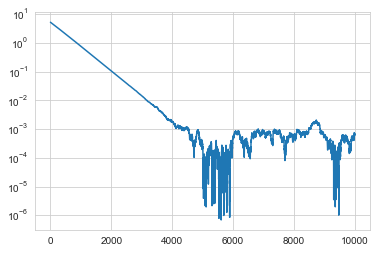

In [81]:
x=np.asarray(dic_sgd_ns[0]['x'])
err=np.asarray([la.norm(x[i,0]-nash[0][0]) for i in range(len(x))])
plt.yscale('log')
plt.plot(err)

## Instructions
After running the above, choose an $x^{\tt so}$; this will be the prices you want to set. The alternative would be to sovle for an optimal $x^{\tt so}(u)$ where we add a regularizer to the cost; otherwise the cost is illposed in terms of $(x,u)$. 

In [83]:
x_so=np.array([[8.6],[4.6]]) # "social optimum"
x0=nash[0]
#x0=np.random.rand(2).reshape(2,1)
print(x0)
ix=incent(x_so,ddgame,x0, d=loc_cap, MAXOUTER=1, MAXINNER=10000, seed=42, n=2, eta=5e-5, m=1,batch=10000, gamma=1e-1, nash=nash[0]) #5e-3"=

[[6.01083529]
 [3.06258509]]
[[6.01083529]
 [3.06258509]]


In [84]:
ix.x_star(ix.u_so), ix.u_so

(array([[8.6],
        [4.6]]),
 array([[185.36859831],
        [155.80896278]]))

In [85]:
ix.u_so, ix.nash, x0

(array([[185.36859831],
        [155.80896278]]),
 array([[6.01083529],
        [3.06258509]]),
 array([[6.01083529],
        [3.06258509]]))

### Checkgin using best response by agents

In [111]:
np.random.seed(42)
u0=np.random.rand(2,loc_cap)
u0=150*np.random.rand(2,loc_cap) #ix.u_so+
print(u0)
M=5000
ix.runIncentOpt(x0,u0, gamma=100, MAXOUTER=M)#ix.u_so+2
print(ix.x_star(ix.us[-1]))
print(ix.us[-1])
err_opt=ix.err_x

[[109.79909127]
 [ 89.79877263]]
[[8.6]
 [4.6]]
[[185.36859832]
 [155.80896277]]


Text(0, 0.5, '$\\Vert u_t-u^{\\tt so}\\Vert_2$')

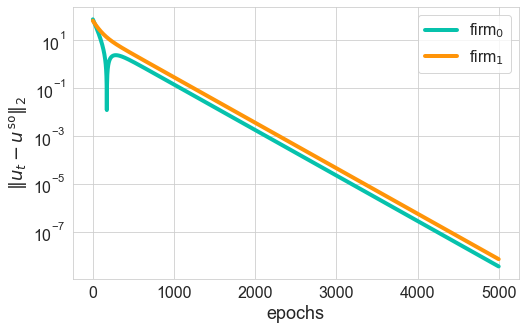

In [112]:
colors=['xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4
us=np.asarray(ix.us)
uso=np.asarray(ix.u_so)
plt.figure(figsize=(8,5))
for j in range(2):
    plt.plot(abs(us[:,j]-uso[j]),color=colors[j],label=r"firm$_{}$".format(j), linewidth=lw)
plt.legend(loc='best', fontsize=fs-2)
plt.yscale('log')
plt.tick_params(labelsize=fs-2)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel(r'$\Vert u_t-u^{\tt so}\Vert_2$',fontsize=fs)

In [35]:
ix.x_star(ix.u_so)

array([[6.],
       [3.]])

In [125]:
np.random.seed(42)
u0=np.random.rand(2,loc_cap)
u0=0*np.random.rand(2,loc_cap) #ix.u_so+

M=100
ix.runIncentBRstop(x0,ix.us[-1], gamma=100, MAXOUTER=M, MEAN=False,eta_outer=1e-3, eps=1e-4)
print(ix.x_star(ix.us[-1]))
print(ix.us[-1])
print(ix.x_s[-1])

5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
[[8.59997621]
 [4.60005252]]
[[185.36465682]
 [155.81674621]]
[[8.60004357]
 [4.5999816 ]]


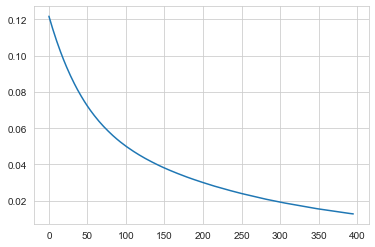

In [121]:
plt.plot(ix.err_u)

In [119]:
ix.stop_sequence

[676,
 40051,
 56,
 36426,
 273384,
 118702,
 123096,
 291118,
 17138,
 246492,
 10732,
 5622,
 21806,
 62187,
 309903,
 49791,
 102615,
 1221,
 294574,
 32127,
 19737,
 61792,
 4545,
 46717,
 2151,
 58570,
 53179,
 337626,
 201943,
 139596,
 177089,
 66911,
 70287,
 31557,
 179360,
 28512,
 3588,
 58093,
 300682,
 74245,
 22751,
 245476,
 33155,
 94588,
 495237,
 10816,
 70136,
 82789,
 5521,
 69202,
 88041,
 125962,
 23091,
 88735,
 106297,
 219677,
 86133,
 102234,
 94829,
 29588,
 8933,
 313672,
 15538,
 74626,
 5348,
 25537,
 53774,
 17282,
 161261,
 74032,
 2243,
 33159,
 73849,
 35211,
 25130,
 171924,
 179906,
 9110,
 9906,
 43431,
 23721,
 48445,
 68578,
 53034,
 190591,
 199024,
 82207,
 22415,
 85574,
 144673,
 342876,
 151355,
 24003,
 144966,
 2995,
 261612,
 34943,
 142329,
 98181,
 72008,
 106989,
 27726,
 139931,
 88602,
 220589,
 29179,
 31929,
 71647,
 25377,
 5402,
 19004,
 93603,
 62721,
 68175,
 113725,
 249928,
 56026,
 40735,
 19561,
 58336,
 111132,
 17821,
 148

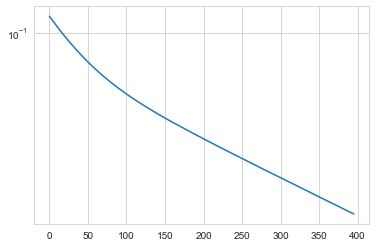

In [124]:
plt.plot(ix.err_u)
plt.yscale('log')

### Now let's run where agents do gradient play

In [120]:
print(ix.us[-1])

[[185.36300956]
 [155.82040282]]


In [106]:
np.random.seed(42)
u0=np.random.rand(2,loc_cap)
u0=0*np.random.rand(2,loc_cap) #ix.u_so+

M=10
ix.runIncent(x0,ix.us[-1], gamma=1, MAXOUTER=M, MEAN=False)
print(ix.x_star(ix.us[-1]))
print(ix.us[-1])
print(ix.x_s[-1])

5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
5e-05
[[8.60191583]
 [4.60110785]]
[[185.50685363]
 [155.92022341]]
[[8.59908639]
 [4.59977724]]


Text(0, 0.5, '$\\Vert u_t-u^{\\tt so}\\Vert_2$')

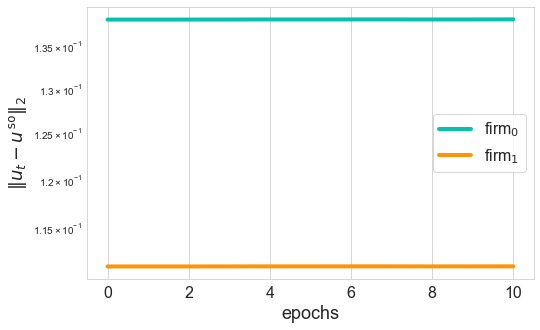

In [108]:
colors=['xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4
us=np.asarray(ix.us)
uso=np.asarray(ix.u_so)
plt.figure(figsize=(8,5))
for j in range(2):
    plt.plot(abs(us[:,j]-uso[j]),color=colors[j],label=r"firm$_{}$".format(j), linewidth=lw)
plt.legend(loc='best', fontsize=fs-2)
plt.yscale('log')
plt.tick_params(labelsize=fs-2)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel(r'$\Vert u_t-u^{\tt so}\Vert_2$',fontsize=fs)

In [45]:
ix.x_sgd_s

[array([[0.37454012],
        [0.95071431]])]

In [122]:
x_test=np.asarray(ix.x_sgd_s[900])

nash[0],x_test.shape

(array([[6.01083529],
        [3.06258509]]),
 (2, 2, 1))

Text(0, 0.5, '$\\Vert x_t-x^{\\tt so}\\Vert_2$')

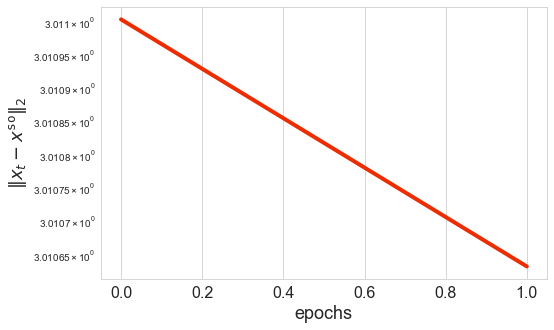

In [123]:
colors=['xkcd:tomato red','xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4

err=np.asarray([la.norm(x_test[i,:]-nash[0]) for i in range(len(x_test))])
plt.figure(figsize=(8,5))
#for j in range(2):
plt.plot(err,color=colors[0], linewidth=lw) #, label="p={}".format(j)ix.err_x
#plt.legend(loc='best', fontsize=fs-2)
plt.yscale('log')
plt.tick_params(labelsize=fs-2)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel(r'$\Vert x_t-x^{\tt so}\Vert_2$',fontsize=fs)

In [58]:
err[-1]

0.027750721350274482

In [102]:
x_so

array([[8.6],
       [4.6]])

In [103]:
x[-1,0], x[-1,1]

(array([8.59986107]), array([4.60025199]))

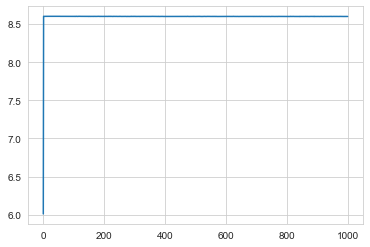

In [99]:
x=np.asarray(ix.x_s)
plt.plot(x[:,0])

(2.0, 10.0)

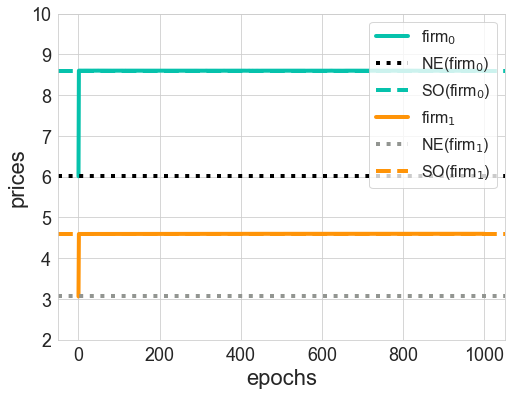

In [97]:
colors=['xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
col_nash=['xkcd:black', 'xkcd:grey']
col_so=['xkcd:turquoise', 'xkcd:tangerine']
fs=18; lw=4
plt.figure(figsize=(8,6))
x=np.asarray(ix.x_s)

for j in range(2):
    plt.plot(x[:,j,0],color=colors[j],label="firm$_{}$".format(j), linewidth=lw)
    plt.axhline(y=ix.nash[j],color=col_nash[j], linewidth=lw, linestyle=':', label=r"NE(firm$_{}$)".format(j))
    plt.axhline(y=ix.x_so[j],color=col_so[j], linewidth=lw, linestyle='--', label=r"SO(firm$_{}$)".format(j))

plt.legend(loc='best', fontsize=fs-2, ncol=1)
plt.tick_params(labelsize=fs)
plt.xlabel(r'epochs', fontsize=fs+4)
plt.ylabel('prices',fontsize=fs+4)
plt.ylim([2,10])

Text(0, 0.5, 'prices')

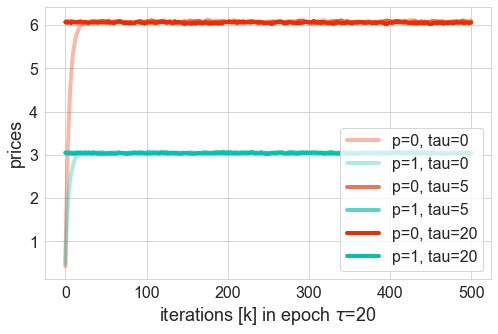

In [31]:
colors=['xkcd:tomato red','xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4
plt.figure(figsize=(8,5))
for tau, alpha in zip([0,5, 20], [0.333,0.666,1 ]):

    x=np.asarray(ix.x_sgd_s[tau])

    for j in range(2):
        plt.plot(x[:,j,0],color=colors[j],label="p={}, tau={}".format(j, tau),alpha=alpha, linewidth=lw)
plt.legend(loc='best', fontsize=fs-2)
plt.tick_params(labelsize=fs-2)
plt.xlabel(r'iterations [k] in epoch $\tau$={}'.format(tau), fontsize=fs)
plt.ylabel('prices',fontsize=fs)


## RGP

In [147]:
x_so=np.array([[8.6],[4.6]]) # "social optimum"
x0=nash[0]
print(x0)
ix=incent(x_so,ddgame,x0, d=loc_cap, MAXOUTER=5000, MAXINNER=500, seed=42, n=2, eta=5e-3, m=1, gamma=1e-1, nash=nash[0]) #5e-3"=

[[5.97977227]
 [3.03653996]]
[[5.97977227]
 [3.03653996]]


In [129]:
print(ix.x_ps), print(ix.u_so_rgp)
ix.u_so

[[15.61121624]
 [ 8.90400095]]
[[-190.56185096]
 [-152.70623768]]


array([[186.02598931],
       [156.16734478]])

In [128]:
ix.Gps

array([[ 23.89464188, -16.78660774],
       [-10.94732094,  35.57321548]])

In [171]:
np.random.seed(42)
u0=np.random.rand(2,loc_cap)
u0=0*np.random.rand(2,loc_cap) #ix.u_so+

M=1000
ix.runIncentRGP(x0,u0, gamma=50, MAXOUTER=M, MEAN=False)
print(ix.x_star_rgp(ix.us_rgp[-1]))
print(ix.us_rgp[-1])
print(ix.x_r[-1])
print(ix.x_ps)

[[8.58155748]
 [4.59060584]]
[[-191.12781356]
 [-152.97080617]]
[[8.6454406 ]
 [4.62283222]]
[[15.61121624]
 [ 8.90400095]]


Text(0, 0.5, '$\\Vert u_t-u^{\\tt so}\\Vert_2$')

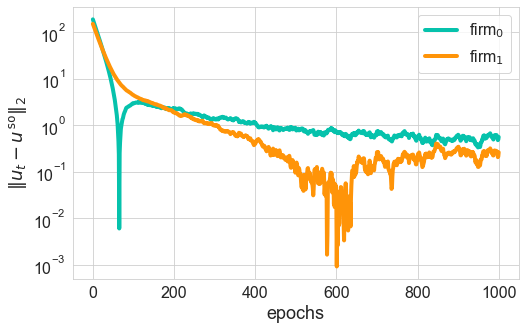

In [166]:
colors=['xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4
us=np.asarray(ix.us_rgp)
uso=np.asarray(ix.u_so_rgp)
plt.figure(figsize=(8,5))
for j in range(2):
    plt.plot(abs(us[:,j]-uso[j]),color=colors[j],label=r"firm$_{}$".format(j), linewidth=lw)
plt.legend(loc='best', fontsize=fs-2)
plt.yscale('log')
plt.tick_params(labelsize=fs-2)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel(r'$\Vert u_t-u^{\tt so}\Vert_2$',fontsize=fs)

In [167]:
ix.x_star_rgp(ix.us_rgp[-1])

array([[8.58155748],
       [4.59060584]])

In [170]:
ix.x_rgd

[array([[8.60949991],
        [4.60213154]]),
 array([[8.60293176],
        [4.60850897]]),
 array([[8.61529361],
        [4.60431006]]),
 array([[8.61084862],
        [4.59576713]]),
 array([[8.59836766],
        [4.5955054 ]]),
 array([[8.59944337],
        [4.59119705]]),
 array([[8.60330894],
        [4.58717389]]),
 array([[8.59855751],
        [4.59407791]]),
 array([[8.60657322],
        [4.59850636]]),
 array([[8.60119547],
        [4.59401089]]),
 array([[8.60475789],
        [4.59234065]]),
 array([[8.62804201],
        [4.58549249]]),
 array([[8.62510451],
        [4.59566437]]),
 array([[8.62364922],
        [4.59150873]]),
 array([[8.61425651],
        [4.59584259]]),
 array([[8.59563723],
        [4.59990397]]),
 array([[8.58713583],
        [4.60161631]]),
 array([[8.58515385],
        [4.60501375]]),
 array([[8.58750632],
        [4.59683091]]),
 array([[8.59729092],
        [4.58405479]]),
 array([[8.58501668],
        [4.59855168]]),
 array([[8.58462816],
        [4.6

Text(0, 0.5, '$\\Vert x_t-x^{\\tt so}\\Vert_2$')

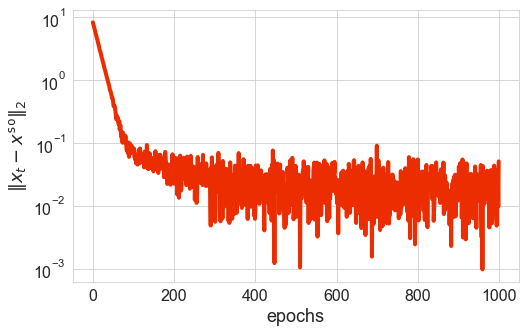

In [172]:
colors=['xkcd:tomato red','xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4


plt.figure(figsize=(8,5))
#for j in range(2):
plt.plot(ix.err_xr,color=colors[0], linewidth=lw) #, label="p={}".format(j)
#plt.legend(loc='best', fontsize=fs-2)
plt.yscale('log')
plt.tick_params(labelsize=fs-2)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel(r'$\Vert x_t-x^{\tt so}\Vert_2$',fontsize=fs)

In [109]:
ix.x_ps

array([[15.61121624],
       [ 8.90400095]])

Text(0, 0.5, 'prices')

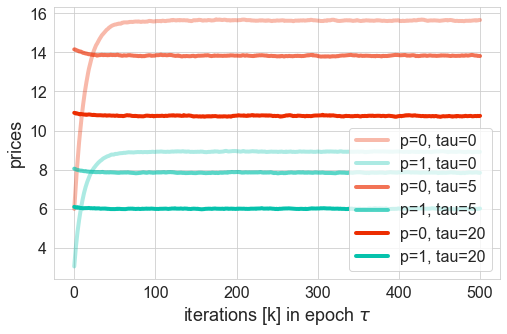

In [175]:
colors=['xkcd:tomato red','xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4
plt.figure(figsize=(8,5))
for tau, alpha in zip([0,5, 20], [0.333,0.666,1 ]):

    x=np.asarray(ix.x_rgd_s[tau])

    for j in range(2):
        plt.plot(x[:,j,0],color=colors[j],label="p={}, tau={}".format(j, tau),alpha=alpha, linewidth=lw)
plt.legend(loc='best', fontsize=fs-2)
plt.tick_params(labelsize=fs-2)
plt.xlabel(r'iterations [k] in epoch $\tau$', fontsize=fs)
plt.ylabel('prices',fontsize=fs)


## DFO

In [254]:
x_so=np.array([[8.6],[4.6]]) # "social optimum"
x0=nash[0]
print(x0)
ix=incent(x_so,ddgame,x0, d=loc_cap, MAXOUTER=5000, MAXINNER=500, seed=42, n=2, eta=5e-3, m=1, gamma=1e-1, nash=nash[0]) #5e-3"=

[[5.97977227]
 [3.03653996]]
[[5.97977227]
 [3.03653996]]


In [253]:
v = np.random.normal(0,1, size=(2,))
v=v/la.norm(v)
la.norm(v)

0.9999999999999999

In [183]:
ix._getgradF(x0,ix.us[0])

array([[-0.10813734],
       [-0.05951513]])

In [198]:
ix.u_so

array([[186.02598931],
       [156.16734478]])

In [262]:
np.random.seed(42)
u0=np.random.rand(2,loc_cap)
u0=0*np.random.rand(2,loc_cap) #ix.u_so+

M=20000
ix.runIncentDFO(x0,u0, gamma=2, MAXOUTER=M, MEAN=False, delta=100) #*0.5)
print(ix.x_star(ix.us[-1]))
print(ix.us[-1])
print(ix.x_s[-1])
print(ix.nash)
print(alpha)

[[7.07190534]
 [3.99923529]]
[[ 66.25487254]
 [106.54295859]]
[[7.10956697]
 [4.00588962]]
[[5.97977227]
 [3.03653996]]
1


In [245]:
la.norm(la.inv(ix.G))

0.028607897252577497

In [246]:
ix.grads

[array([[-0.03253844],
        [-0.01902335]]),
 array([[ 0.00768042],
        [-0.00845174]]),
 array([[ 0.00141515],
        [-0.00879116]]),
 array([[ 0.00560567],
        [-0.00673144]]),
 array([[ 0.00675619],
        [-0.00496933]]),
 array([[ 0.00517013],
        [-0.00637894]]),
 array([[ 0.00324285],
        [-0.00749194]]),
 array([[ 0.0048786 ],
        [-0.00701928]]),
 array([[ 0.00298685],
        [-0.0080835 ]]),
 array([[ 0.00195147],
        [-0.0088237 ]]),
 array([[ 0.00309673],
        [-0.00805449]]),
 array([[ 0.00257534],
        [-0.00793047]]),
 array([[ 0.00084632],
        [-0.00859957]]),
 array([[ 0.00074984],
        [-0.0090242 ]]),
 array([[ 0.00168123],
        [-0.0089512 ]]),
 array([[ 0.00204826],
        [-0.00909625]]),
 array([[ 0.00137724],
        [-0.00975584]]),
 array([[ 0.00229396],
        [-0.0093692 ]]),
 array([[ 0.00420561],
        [-0.00873035]]),
 array([[ 0.00375453],
        [-0.00919119]]),
 array([[ 0.00336984],
        [-0.00903

In [247]:
ix.grad_dfo

[array([-0.05741902,  0.0684862 ]),
 array([0.0243968 , 0.01423619]),
 array([-0.01583266,  0.00617921]),
 array([-0.01679797, -0.00175959]),
 array([ 0.01196249, -0.00656968]),
 array([-0.01406219,  0.00494178]),
 array([ 0.00621025, -0.01391126]),
 array([0.01137567, 0.0119194 ]),
 array([ 0.01433601, -0.00889057]),
 array([0.01718364, 0.00506739]),
 array([-0.01318646,  0.01064503]),
 array([-0.01561615,  0.00136997]),
 array([-0.00343279,  0.01514964]),
 array([-0.01690907,  0.0005548 ]),
 array([-0.01456459, -0.01053875]),
 array([-0.01907412,  0.00094094]),
 array([ 0.02052188, -0.0020658 ]),
 array([0.01647636, 0.0123103 ]),
 array([ 0.00270682, -0.02133573]),
 array([-0.02063531,  0.00894509]),
 array([0.02054641, 0.00489696]),
 array([-0.01593606,  0.01641542]),
 array([-0.00497009,  0.02051509]),
 array([0.00632497, 0.02116472]),
 array([0.00796504, 0.02067534]),
 array([0.01215759, 0.02007597]),
 array([ 0.00353473, -0.02297357]),
 array([ 0.01845626, -0.01420384]),
 array([

Text(0, 0.5, '$\\Vert u_t-u^{\\tt so}\\Vert_2$')

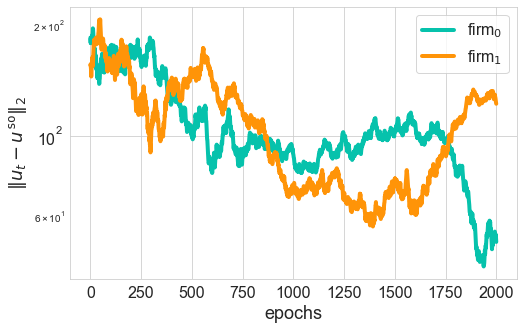

In [260]:
colors=['xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4
us=np.asarray(ix.us)
uso=np.asarray(ix.u_so)
plt.figure(figsize=(8,5))
for j in range(2):
    plt.plot(abs(us[:,j]-uso[j]),color=colors[j],label=r"firm$_{}$".format(j), linewidth=lw)
plt.legend(loc='best', fontsize=fs-2)
plt.yscale('log')
plt.tick_params(labelsize=fs-2)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel(r'$\Vert u_t-u^{\tt so}\Vert_2$',fontsize=fs)

Text(0, 0.5, '$\\Vert x_t-x^{\\tt so}\\Vert_2$')

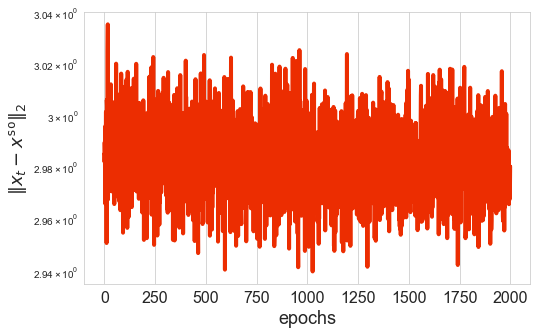

In [251]:
colors=['xkcd:tomato red','xkcd:turquoise', 'xkcd:tangerine','xkcd:cerulean', 'xkcd:orange', 'xkcd:kelly green','xkcd:golden rod']
ls=['-','--']
fs=18; lw=4


plt.figure(figsize=(8,5))
#for j in range(2):
plt.plot(ix.err_x,color=colors[0], linewidth=lw) #, label="p={}".format(j)
#plt.legend(loc='best', fontsize=fs-2)
plt.yscale('log')
plt.tick_params(labelsize=fs-2)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel(r'$\Vert x_t-x^{\tt so}\Vert_2$',fontsize=fs)